In [2]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

# load the precomputed embeddings if available

train_embeds = np.load('train_embeds.npy')
val_embeds = np.load('val_embeds.npy')
train_machine_label = np.load('train_machine_label.npy')
val_machine_label = np.load('val_machine_label.npy')
train_binary_label = np.load('train_binary_label.npy')
val_binary_label = np.load('val_binary_label.npy')

In [25]:
train_embeds.shape, \
val_embeds.shape, \
train_machine_label.shape, \
val_machine_label.shape, \
#train_binary_label.shape, \
#val_binary_label.shape

((6112, 512), (2518, 512), (6112,), (2518,))

In [4]:
print(train_binary_label[0:10])
x, y = np.where(train_binary_label[0:10]==[1., 0.])
x[np.where(y==0)]

[[0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


array([2, 3, 4, 5, 6, 7, 8, 9])

In [5]:
x, y = np.where(train_binary_label==[1., 0.])
train_normal_inds = x[np.where(y==0)]

train_embeds_normal = train_embeds[train_normal_inds]
train_binary_label_normal = train_binary_label[train_normal_inds]
train_machine_label_normal = train_machine_label[train_normal_inds]

In [6]:
train_embeds_normal.shape, train_binary_label_normal.shape, train_machine_label_normal.shape

((31903, 512), (31903, 2), (31903,))

# Binary classification AUC

In [7]:
train_binary_labs = []
val_binary_labs = []

for k in train_binary_label:
    if k[1] == 1.:
        train_binary_labs.append('abnormal')
    elif k[0] == 1.:
        train_binary_labs.append('normal')
        
for k in val_binary_label:
    if k[1] == 1.:
        val_binary_labs.append('abnormal')
    elif k[0] == 1.:
        val_binary_labs.append('normal')

In [8]:
import sklearn
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=200, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski')
knn.fit(train_embeds, np.array(train_binary_labs))

#proba = knn.predict_proba(val_embeds)

KNeighborsClassifier(n_neighbors=200)

In [10]:
import matplotlib.pyplot as plt

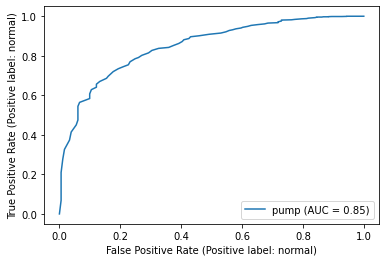

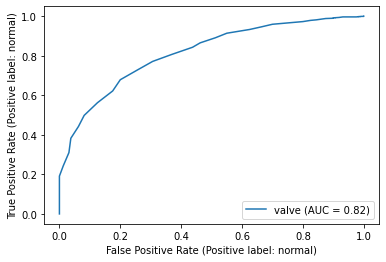

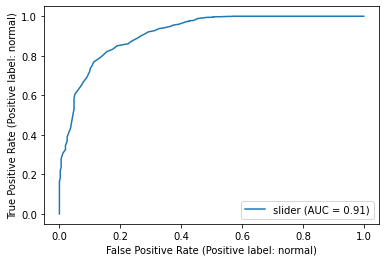

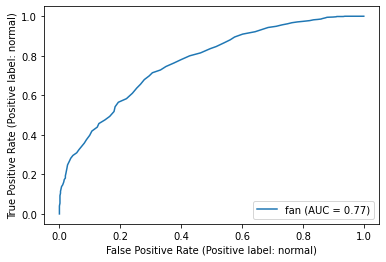

In [15]:
MACHINE_CODE = {
    'pump': 0, 'valve': 1, 'slider': 2, 'fan': 3
}

for _key in ['pump', 'valve', 'slider', 'fan']:
    inds = np.where(val_machine_label == MACHINE_CODE[_key])[0]
    
    sklearn.metrics.RocCurveDisplay.from_estimator(knn, val_embeds[inds], np.array(val_binary_labs)[inds], name=_key)
    plt.show()

# Ignore the below stuff if the embeddings are already available

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Preliminaries
import time
import glob
import math
import random
import copy
import shutil
import sys
sys.path.append('../src')
import typing as tp
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import collections.abc as container_abcs

from tqdm import tqdm
import yaml
from joblib import delayed, Parallel

# Visuals and CV2
import cv2

import pandas as pd
import numpy as np
from torch.cuda import amp
import matplotlib.pyplot as plt

# albumentations for augs
import albumentations
from albumentations.pytorch.transforms import ToTensorV2

#torch
import torch
import timm
import torch
import torch.nn as nn
from torch.nn import Parameter
from torch.nn import functional as F
from torch.utils.data import Dataset,DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from torch.optim import Adam, lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler

#from cuml.neighbors import NearestNeighbors

from pytorch_metric_learning import losses

from dataset import SpectrogramDataset


ROOT = Path.cwd()
#INPUT_ROOT = ROOT / "../../../data" #"data" / "wav_data"
INPUT_ROOT = ROOT / "../../../machine_sound"

class CFG:
    seed = 42
    model_name = 'tf_efficientnet_b4_ns' #'efficientnet_b3' #efficientnet_b0-b7
    img_size = 224
    scheduler = 'CosineAnnealingLR'
    T_max = 10
    lr = 1e-5
    min_lr = 1e-6
    batch_size = 16
    weight_decay = 1e-6
    num_epochs = 50
    num_classes = 4
    embedding_size = 512
    n_fold = 0
    n_accumulate = 4
    temperature = 0.1
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
#   torch.backends.cudnn.deterministic = True  # type: ignore
#   torch.backends.cudnn.benchmark = True  # type: ignore


@contextmanager
def timer(name: str) -> None:
    """Timer Util"""
    t0 = time.time()
    print("[{}] start".format(name))
    yield
    print("[{}] done in {:.0f} s".format(name, time.time() - t0))


class SupervisedContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.1):
        super(SupervisedContrastiveLoss, self).__init__()
        self.temperature = temperature

    def forward(self, feature_vectors, labels):
        # Normalize feature vectors
        feature_vectors_normalized = F.normalize(feature_vectors, p=2, dim=1)
        # Compute logits
        logits = torch.div(
            torch.matmul(
                feature_vectors_normalized, torch.transpose(feature_vectors_normalized, 0, 1)
            ),
            self.temperature,
        )
        return losses.NTXentLoss(temperature=0.07)(logits, torch.squeeze(labels))

def get_loaders_for_training(
    args_dataset: tp.Dict, args_loader: tp.Dict,
    train_file_list: tp.List[str], val_file_list: tp.List[str]
):
    # # make dataset
    train_dataset = SpectrogramDataset(train_file_list, is_val=True, **args_dataset)
    val_dataset = SpectrogramDataset(val_file_list, is_val=True, **args_dataset)
    # # make dataloader
    train_loader = DataLoader(train_dataset, **args_loader["train"])
    val_loader = DataLoader(val_dataset, **args_loader["val"])

    return train_loader, val_loader, train_dataset, val_dataset



# tmp_list = []
# npz_files = glob.glob(str(INPUT_ROOT) + '/*/*')
# for npz_file in npz_files:
#     wav_fpath = npz_file
#     wav_fname = npz_file.split('/')[-1]
#     machine_db_type, operation_type, machine_id, file_id, channel_no = npz_file.split('/')[-1].split('-')
#     machine_type = machine_db_type.split('_')[-1]
#     tmp_list.append( [machine_type, machine_id, operation_type,
#                                          wav_fname, wav_fpath])

train_txt = '../../task1_data_2018/TUT-urban-acoustic-scenes-2018-development/evaluation_setup/fold1_train.txt'
val_txt = '../../task1_data_2018/TUT-urban-acoustic-scenes-2018-development/evaluation_setup/fold1_evaluate.txt'

#['slider', 'id_04', 'normal', '00000274.wav', #'/home/anudeep/development/machine_sound_classification/src/../../../machine_sound/0_dB_slider/slider/id_04/normal/00000274.wav']
train_data = []
val_data = []

for k in open(train_txt).readlines():
    f_name, scene = k.split('\t')
    scene = scene[:-1]

    _temp = [scene, scene, 'normal', f_name, '../../task1_data_2018/TUT-urban-acoustic-scenes-2018-development/'+f_name]
    train_data.append(_temp)

for k in open(val_txt).readlines():
    f_name, scene = k.split('\t')
    scene = scene[:-1]

    _temp = [scene, scene, 'normal', f_name, '../../task1_data_2018/TUT-urban-acoustic-scenes-2018-development/'+f_name]
    val_data.append(_temp)


train_df = pd.DataFrame(
    train_data, columns=["machine_type", "id_type", "operation_type",
                        "wav_filename", "wav_file_path"])

val_df = pd.DataFrame(
    val_data, columns=["machine_type", "id_type", "operation_type",
                        "wav_filename", "wav_file_path"])



#TODO: Here we can select to use only normal or abnormal data for training

train_file_list = train_df[["wav_file_path", "machine_type"]].values.tolist()
val_file_list = val_df[["wav_file_path", "machine_type"]].values.tolist()


with open('../params/train_config_metricLearning.yaml') as settings_str:
    settings = yaml.safe_load(settings_str)

for k, v in settings.items():
    print("[{}]".format(k))
    print(v)

set_seed(settings["globals"]["seed"])
device = torch.device(settings["globals"]["device"])

# # # get loader
train_loader, test_loader, train_dataset, test_dataset = get_loaders_for_training(
    settings["dataset"]["params"], settings["loader"], train_file_list, val_file_list)

train_loader, valid_loader, train_dataset, valid_dataset = get_loaders_for_training(
    settings["dataset"]["params"], settings["loader"], train_file_list, val_file_list)

dataset_sizes = {
    'train' : train_df.shape[0],
    'valid' : val_df.shape[0],
    'test' : val_df.shape[0]
}
dataloaders = {
    'train' : train_loader,
    'valid' : valid_loader,
    'test' : valid_loader
}

model = timm.create_model(CFG.model_name, pretrained=True)
in_features = model.classifier.in_features
model.classifier = nn.Linear(in_features, CFG.embedding_size)

out = model(torch.randn(1, 3, CFG.img_size, CFG.img_size))
print(f'Embedding shape: {out.shape}')

[globals]
{'seed': 1213, 'device': 'cuda', 'num_epochs': 50, 'output_dir': '../training_outputs/metric_learning_urban_acoustic3/', 'use_fold': 0, 'target_sr': 32000}
[dataset]
{'name': 'SpectrogramDataset', 'params': {'img_size': 224, 'melspectrogram_parameters': {'n_mels': 128, 'n_fft': 2048, 'hop_length': 512, 'power': 2.0, 'fmin': 20, 'fmax': 8000}, 'metric_learning': True, 'spectrogram_transforms': 'spec_augment'}}
[loader]
{'train': {'batch_size': 8, 'shuffle': True, 'num_workers': 4, 'pin_memory': False, 'drop_last': True}, 'val': {'batch_size': 8, 'shuffle': False, 'num_workers': 2, 'pin_memory': False, 'drop_last': False}}
[model]
{'name': 'resnest50_fast_1s1x64d', 'params': {'pretrained': True, 'n_classes': 2}}
Embedding shape: torch.Size([1, 512])


In [3]:
# Load weights
import glob
from collections import defaultdict
load_path = ''
weight_files = glob.glob("../training_outputs/metric_learning_urban_acoustic3/*.bin")#"#preprocess*")
weight_files.sort()

curr = weight_files[0]
for ctr, k in enumerate(weight_files):
    print(ctr, "\t", weight_files[ctr])
    curr = k 
    
indx = int(input("please enter your selection"))
load_path = weight_files[indx]

model = model.to(device)
model.load_state_dict(torch.load(load_path))
#model.eval()

0 	 ../training_outputs/metric_learning_urban_acoustic3/Model_0.0039833327452041874_epoch_24.bin
1 	 ../training_outputs/metric_learning_urban_acoustic3/Model_0.004119126982779802_epoch_22.bin
2 	 ../training_outputs/metric_learning_urban_acoustic3/Model_0.004166948495875095_epoch_16.bin
3 	 ../training_outputs/metric_learning_urban_acoustic3/Model_0.004368556030183391_epoch_15.bin
4 	 ../training_outputs/metric_learning_urban_acoustic3/Model_0.00439442968479786_epoch_12.bin
5 	 ../training_outputs/metric_learning_urban_acoustic3/Model_0.004427971251788264_epoch_5.bin
6 	 ../training_outputs/metric_learning_urban_acoustic3/Model_0.005370315954176453_epoch_4.bin
7 	 ../training_outputs/metric_learning_urban_acoustic3/Model_0.00561164917620905_epoch_1.bin


please enter your selection 0


<All keys matched successfully>

In [ ]:
############## Inference Using Trained model ###############

all_embeds = []
machine_labels = []
#binary_labels = []

for _phase in ['train', 'valid']:
    embeds = []
    machine_label = []
    binary_label = []
    with torch.no_grad():
        phase = _phase
        # Iterate over data
        for inputs,labels in tqdm(dataloaders[phase]):
            inputs = inputs.to(CFG.device)
            #print(inputs)
            #labels = labels.to(CFG.device)
            machine_label.append(labels.cpu().numpy())
            #binary_label.append(labels[1])

            feat = model( inputs )
            embeddings = feat.detach().cpu().numpy()
            embeds.append(embeddings)

    image_embeddings = np.concatenate(embeds)
    t1 = np.concatenate(machine_label)
    #t2 = np.concatenate(binary_label)
    all_embeds.append(image_embeddings)
    machine_labels.append(t1)
    #binary_labels.append(t2)
    print(f'Our image embeddings shape is {image_embeddings.shape}')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 765/765 [12:29<00:00,  1.02it/s]


Our image embeddings shape is (6120, 512)


 14%|███████████████▉                                                                                                  | 44/315 [01:20<07:04,  1.56s/it]

In [5]:
labels

tensor([6, 6, 6, 6, 6, 6])

In [6]:
np.array(machine_labels).shape

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


(2,)

In [7]:
train_embeds = all_embeds[0]
val_embeds = all_embeds[1]
train_machine_label = machine_labels[0]
val_machine_label = machine_labels[1]
#train_binary_label = binary_labels[0]
#val_binary_label = binary_labels[1]

In [8]:
train_embeds.shape, val_embeds.shape

((6120, 512), (2518, 512))

In [6]:
np.save('train_embeds.npy', train_embeds)
np.save('val_embeds.npy', val_embeds)
np.save('train_machine_label.npy', train_machine_label)
np.save('val_machine_label.npy', val_machine_label)
np.save('train_binary_label.npy', train_binary_label)
np.save('val_binary_label.npy', val_binary_label)

# Idea 1
<p> if we have both normal and anomaly samples in train foldself. </p>
<p> and Knn neighbour of a test sample is abnormal (or normal) </p>

In [9]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

In [15]:
# Get neighbors from image_embeddings
# fit model
KNN = 25
knn_model = NearestNeighbors(n_neighbors = KNN)
knn_model.fit(train_embeds)
distances, indices = knn_model.kneighbors(val_embeds)

In [16]:
def most_frequent(List):
    return max(set(List), key = List.count)

In [17]:
np.unique(val_machine_label)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [18]:
pred_machine = []
#pred_binary = []

for k in range(distances.shape[0]):
    #curr_binary = list(train_binary_label[indices[k]])
    curr_machine = list(train_machine_label[indices[k]])
    
    #print(curr_machine, val_machine_label[k])
    # if 'abnormal' in curr_binary[0:5]:
    #     pred_binary.append('abnormal')
    # else:
    #     pred_binary.append(most_frequent(curr_binary))
        
    pred_machine.append(most_frequent(curr_machine))

In [14]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(val_machine_label, pred_machine))
print(confusion_matrix(val_machine_label, pred_machine))

              precision    recall  f1-score   support

           0       0.14      0.25      0.18       265
           1       0.14      0.10      0.12       279
           2       0.08      0.12      0.10       259
           3       0.13      0.16      0.14       247
           4       0.12      0.11      0.11       216
           5       0.20      0.09      0.12       246
           6       0.10      0.02      0.03       261
           7       0.19      0.07      0.11       242
           8       0.13      0.23      0.17       261
           9       0.11      0.11      0.11       242

    accuracy                           0.13      2518
   macro avg       0.13      0.13      0.12      2518
weighted avg       0.13      0.13      0.12      2518

[[65 12 49 34 20  7  6  4 48 20]
 [51 27 59 41 32  5  0  1 39 24]
 [50 35 32 33 18 22  7 11 33 18]
 [60 23 40 39 12  6  1  5 46 15]
 [41 16 31 24 23 13  3  9 36 20]
 [47 26 35 36 18 21  6  1 18 38]
 [43 10 36 18 18  6  5 17 75 33]
 [37 10 35

In [10]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(val_machine_label, pred_machine))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1633
           1       1.00      1.00      1.00      1572
           2       0.99      0.98      0.99      1585
           3       0.98      0.99      0.99      2103

    accuracy                           0.99      6893
   macro avg       0.99      0.99      0.99      6893
weighted avg       0.99      0.99      0.99      6893



In [11]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(val_binary_label, pred_binary))

print(classification_report(val_binary_label, pred_binary))

[[1172  111]
 [ 930 4680]]
              precision    recall  f1-score   support

    abnormal       0.56      0.91      0.69      1283
      normal       0.98      0.83      0.90      5610

    accuracy                           0.85      6893
   macro avg       0.77      0.87      0.80      6893
weighted avg       0.90      0.85      0.86      6893



In [12]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(val_binary_label, pred_binary))

print(classification_report(val_binary_label, pred_binary))

[[1172  111]
 [ 930 4680]]
              precision    recall  f1-score   support

    abnormal       0.56      0.91      0.69      1283
      normal       0.98      0.83      0.90      5610

    accuracy                           0.85      6893
   macro avg       0.77      0.87      0.80      6893
weighted avg       0.90      0.85      0.86      6893



# only normal data in train set

<p> Idea 2 </p>
<p> If we have only normal in train fold</p>
<p> then knn neighbour of test sample distance can be used to</p>
<p> judge it as normal or abnormal ?</p>

In [18]:
from sklearn.neighbors import NearestNeighbors
# Get neighbors from image_embeddings
# fit model
KNN = 50
knn_model = NearestNeighbors(n_neighbors = KNN)
knn_model.fit(train_embeds_normal)
distances, indices = knn_model.kneighbors(val_embeds)

In [19]:
pred_machine = []
pred_binary = []
avg_distance = []

for k in range(distances.shape[0]):
    curr_binary = list(train_binary_label_normal[indices[k]])
    curr_machine = list(train_machine_label_normal[indices[k]])
    avg_dist = distances[k][0]#np.mean(distances[k])
    
    #if 'abnormal' in curr_binary:
    #    pred_binary.append('abnormal')
    #else:
    #pred_binary.append(most_frequent(curr_binary))
    pred_machine.append(most_frequent(curr_machine))
    avg_distance.append(avg_dist)

In [20]:
pred_binary = []
thresh = np.mean(avg_distance) + 2*np.std(avg_distance)
for k in avg_distance:
    if k <= thresh:
        pred_binary.append('normal')
    else:
        pred_binary.append('abnormal')

In [21]:
len(pred_binary)

6893

In [22]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(val_machine_label, pred_machine))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1633
           1       1.00      1.00      1.00      1572
           2       0.99      0.98      0.99      1585
           3       0.98      0.99      0.98      2103

    accuracy                           0.99      6893
   macro avg       0.99      0.99      0.99      6893
weighted avg       0.99      0.99      0.99      6893



In [15]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(val_machine_label, pred_machine))

              precision    recall  f1-score   support

           0       0.97      0.94      0.96      1633
           1       1.00      1.00      1.00      1572
           2       0.97      0.94      0.96      1585
           3       0.93      0.97      0.95      2103

    accuracy                           0.96      6893
   macro avg       0.97      0.96      0.97      6893
weighted avg       0.97      0.96      0.96      6893



In [23]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(val_binary_label, pred_binary))

print(classification_report(val_binary_label, pred_binary))

[[ 104 1179]
 [  86 5524]]
              precision    recall  f1-score   support

    abnormal       0.55      0.08      0.14      1283
      normal       0.82      0.98      0.90      5610

    accuracy                           0.82      6893
   macro avg       0.69      0.53      0.52      6893
weighted avg       0.77      0.82      0.76      6893



In [16]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(val_binary_label, pred_binary))

print(classification_report(val_binary_label, pred_binary))

[[  68 1215]
 [ 136 5474]]
              precision    recall  f1-score   support

    abnormal       0.33      0.05      0.09      1283
      normal       0.82      0.98      0.89      5610

    accuracy                           0.80      6893
   macro avg       0.58      0.51      0.49      6893
weighted avg       0.73      0.80      0.74      6893

